<a href="https://colab.research.google.com/github/ProjectXMG999/hate_speech_detection_Project/blob/main/NLP_hate_detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPU set-up

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Load libraries

In [ ]:
# !pip install transformers

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from string import punctuation
from collections import Counter
import random
import operator
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertModel, BertTokenizer

## Load data

Note that I will only use two of the columns: 'text' and 'HOF' (i.e. the label). The other columns (sentiment towards Trump, Biden and West) are superfluous to the current (simple) task. 

In [ ]:
def load_data(path, sample_size=5, cols=['text', 'HOF'], label=None):
    """Helper function that loads data from a given path into a pandas
       DataFrame, using only the specified cols. Also prints basic info
       about the dataset size and displays a sample of the rows. 
    """
    
    df = pd.read_csv(path, sep='\t', usecols=cols)
    
    print(f"\nThere are {df.shape[0]} tweets in the {label} dataset.")
    print("\nHere's a sample:\n")
    display(df.sample(sample_size))
    
    return df

In [ ]:
# Colab
train = load_data('train.tsv', label='train')
test = load_data('test.tsv', label='test')

FileNotFoundError: ignored

In [ ]:
# Local
# train = load_data(path=Path.cwd()/'data/GrimmingerKlingerWASSA2021/train.tsv', label='train')
# test = load_data(path=Path.cwd()/'data/GrimmingerKlingerWASSA2021/test.tsv', label='test')

In [ ]:
# Are there any duplicates?
assert len(train['text'].drop_duplicates()) == len(train['text'])
assert len(test['text'].drop_duplicates()) == len(test['text'])

## Quick inspection / visualisation

In [ ]:
# !pip install matplotlib --upgrade

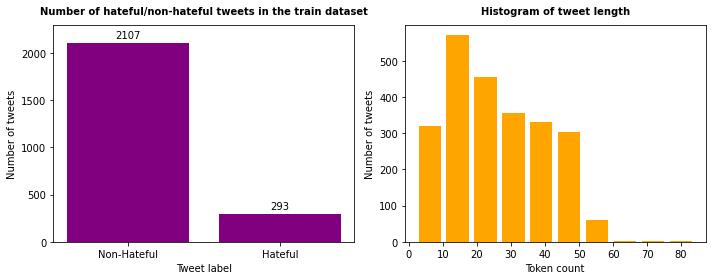

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Distribution by class
ax[0].bar(x = train['HOF'].unique(), # Data labels
       height = train['HOF'].value_counts().values, # Num of tweets in each category
       color='purple')

ax[0].bar_label(ax[0].containers[0], label_type='edge', padding=3) # Annotate bars
ax[0].set_ylim(0, 2300) # Raise upper limit of y-axis, to accommodate labels

ax[0].set_title("Number of hateful/non-hateful tweets in the train dataset", 
             fontweight='bold', fontsize=10, y = 1.02)
ax[0].set_ylabel("Number of tweets")
ax[0].set_xlabel('Tweet label')

# Distribution by length
ax[1].hist([len(tweet) for tweet in train['text'].apply(lambda x: x.split())], 
           color='orange', rwidth=0.8)
ax[1].set_xlabel('Token count')
ax[1].set_ylabel('Number of tweets')
ax[1].set_title("Histogram of tweet length", 
                fontweight='bold', fontsize=10, y = 1.02)


plt.tight_layout()
plt.show()

## Preprocess data
At this stage, I will just map the labels to integers. Later, I will conduct more preprocessing.

In [ ]:
# Map labels to binary integers
label2id = {'Non-Hateful': 0, 'Hateful': 1}
train['HOF'] = train['HOF'].apply(lambda x: label2id[x])
test['HOF'] = test['HOF'].apply(lambda x: label2id[x])

## Deal with class imbalances
For simplicity / for now, I'll just downsample from the majority ('Non-Hateful') class.

In [ ]:
print('Before downsampling: ')
print(f"Hateful: {len(train[train['HOF']==1])}")
print(f"Non-Hateful: {len(train[train['HOF']==0])}")

train_hateful = train[train['HOF']==1]
train_nonhateful = train[train['HOF']==0].sample(len(train_hateful))
train_downsampled = pd.concat([train_hateful, train_nonhateful], axis=0).sample(frac=1)

print('\nAfter downsampling: ')
print(f"Hateful: {len(train_downsampled[train_downsampled['HOF']==1])}")
print(f"Non-Hateful: {len(train_downsampled[train_downsampled['HOF']==0])}")

Before downsampling: 
Hateful: 293
Non-Hateful: 2107

After downsampling: 
Hateful: 293
Non-Hateful: 293


## Split train data set into train and development sets
To provide a way to assess the model's performance after each training loop.

In [ ]:
# Split train data set into train and development sets
train, dev = train_test_split(train_downsampled, test_size=0.5, stratify=train_downsampled['HOF'])

## Prepare data


* `torch.utils.data.Dataset` - stores the samples and their corresponding labels. I also use it to create a simple pipeline for cleaning and tokenizing the tweets. I will use the `bert-base-uncased` tokenizer so that the tokenizer matches the model. This is because (1) the model has a specific, fixed vocabulary, and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words. 
* `torch.utils.data.DataLoader` - wraps an iterable around the `Dataset`, enabling us to iterate through the samples. Can also be used to transform the data (if you provide a custom `collate_fn`). 


In [ ]:
# Clean the tweets' text
def clean_text(tweet):
    """A function that performs basic cleaning of a tweet's text.
    """
    
    # Replace mentions and URLs with special token
    tweet = re.sub(r"@[A-Za-z0-9_-]+",'USR',tweet)
    tweet = re.sub(r"http\S+",'URL',tweet)
    
    # Remove \n and \t characters
    tweet = tweet.replace('\n', ' ')
    tweet = tweet.replace('[NEWLINE]', ' ')
    tweet = tweet.replace('\t', ' ')
    
    # Strip whitespace
    tweet = tweet.strip()
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # return [w.strip(punctuation) for w in tweet.split() if w.strip(punctuation)!='']
    return tweet

# train['cleaned_text'] = train['text'].apply(lambda x: clean_text(x))
# test['cleaned_text'] = test['text'].apply(lambda x: clean_text(x))

In [ ]:
# Define Dataset class which cleans, tokenizes and encodes data
class BERTDataset(Dataset):
    
    def __init__(self, data):
        
        # Initialize BERT tokenizer
        # Note that I need to specify cache_dir because I'm using a venv
        self.tok = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir=Path.cwd()/'venv/lib/python3.8/site-packages')
        
        # Clean tweets
        self.cleaned_tweets = data['text'].apply(lambda x: clean_text(x))
        
        # Truncate and encode tweets, up to max_length of 60
        # While this is lower than BERT's max (512), it was chosen for computational speed
        self.tweets = list(self.cleaned_tweets.apply(self.tok.encode, max_length=60, truncation=True))
        
        # Store labels
        self.labels = list(data['HOF'])
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        return tweet, label
    
# Inspect an example
# BD = BERTDataset(train.iloc[:5])
# next(iter(BD))

In [ ]:
# Define collate function to be passed to DataLoader
def bert_collate(batch):
    
    # Store batch size
    batch_size = len(batch)
    
    # Separate tweets and labels
    tweets = [t for t, _ in batch]
    labels = torch.tensor([l for _, l in batch]).long()
    
    # Store length of longest tweet in batch
    max_len = max(len(t) for t in tweets)
    
    # Create padded tweet and attention mask tensors
    tweets_pad = torch.zeros((batch_size, max_len)).long()
    masks_pad = torch.zeros((batch_size, max_len)).long()
    for i, t in enumerate(tweets):
        tweets_pad[i, :len(t)] = torch.tensor(t)
        masks_pad[i, :len(t)] = 1
        
    return tweets_pad, masks_pad, labels

In [ ]:
%%time

# Create data sets
train_dataset = BERTDataset(train)
dev_dataset = BERTDataset(dev)
test_dataset = BERTDataset(test)

CPU times: user 1.21 s, sys: 16.8 ms, total: 1.23 s
Wall time: 1.6 s


In [ ]:
# Create data loaders using torch.utils.data.DataLoader class
# Using shuffle=True instead of specifying RandomSampler
train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=bert_collate, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=100, collate_fn=bert_collate)
test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=bert_collate)

In [ ]:
# Inspect
for (idx, batch) in enumerate(train_loader):

    print(f'\n\n--------------------- Batch {idx} ---------------------\n')
    
    # Print the text
    print(f"There are {len(batch[0])} encoded tweets in this batch.")
    print('Tweets (encoded): ', batch[0])

    # Print the label
    print(f"There are {len(batch[2])} encoded labels in this batch. Here they are: ")
    print('Labels: ', batch[2])

In [ ]:
# Define BERT classifier
class BERTClassifier(nn.Module):
    
    def __init__(self):
        
        # Specify network layers
        # Note that I need to specify cache as I'm using a venv
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', cache_dir=Path.cwd()/'venv/lib/python3.8/site-packages')
        self.linear = nn.Linear(768, 4)
        
        # Define dropout
        self.dropout = nn.Dropout(0.2)
        
        # Freeze BERT layers
        for n, p in self.bert.named_parameters():
            p.requires_grad = False
            
    def forward(self, tweets, masks):
        
        # Define flow of tensors through the network
        output_bert = self.bert(tweets, attention_mask=masks)[0].mean(axis=1)
        return self.linear(self.dropout(output_bert))

In [ ]:
# Initialise model
model = BERTClassifier()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The warning above: This only means that the pretrained head of the BERT model is discarded, and replaced with a randomly initialised classification head. It doesn't matter that this is randomly initialised because we will now fine-tune this new model head via training below. 

In [ ]:
# Move model to device
model = model.to(device)

In [ ]:
# Define optimiser, objective function and epochs
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 5

In [ ]:
%%time

# Train model
for epoch_i in range(1, epochs):
    
    # ========================================
    #               Training
    # ========================================
        
    # Put model into training mode. This is necessary so that the `Dropout`
    # layers are activated. 
    model.train()
    
    # For each batch of the training data...
    for i, batch in enumerate(tqdm(train_loader)):
        
        # Step 1. Since PyTorch accumulates gradients, clear any previously
        # calculated gradients before performing a backward pass.
        # PyTorch doesn't do this automatically because it can be useful while
        # training RNNs.
        optimizer.zero_grad()
        
        # Step 2. Extract data and move to device.
        tweets, masks, labels = [t.to(device) for t in batch]
        
        # Step 3. Forward pass - note that calling `model()` will in turn call
        # the model's `forward()` function.
        output = model(tweets, masks)
        
        # Step 4. Compute loss.
        loss = criterion(output, labels)
        
        # Step 5. Perform backward pass to calculate gradients wrt each w and b term. 
        loss.backward()
        
        # Step 6. Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Step 7. Update parameters and take a step using the computed gradient.
        optimizer.step()
        
    # ========================================
    #               Validation
    # ========================================
    
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    # Put model into evaluation mode, thereby deactivating Dropout layer.
    model.eval()
    
    y_true = list()
    y_pred = list()
    
    with torch.no_grad(): # We no longer need it to store computation graph.
        for batch in dev_loader:
            tweets, masks, labels = [t.to(device) for t in batch]
            output = model(tweets, masks)
            max_output = output.argmax(dim=1)
            y_true.extend(labels.tolist())
            y_pred.extend(max_output.tolist())
            
    print(f"Accuracy after {epoch_i} epoch(s): {accuracy_score(y_true, y_pred)}")

100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


Accuracy after 1 epoch(s): 0.5767918088737202


100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


Accuracy after 2 epoch(s): 0.6109215017064846


100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


Accuracy after 3 epoch(s): 0.6416382252559727


100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


Accuracy after 4 epoch(s): 0.6757679180887372
CPU times: user 8.3 s, sys: 17.4 ms, total: 8.32 s
Wall time: 8.28 s


In [ ]:
%%time

# ========================================
#               Evaluation
# ========================================

# Evaluate model on test data
model.eval()

y_true = list()
y_pred = list()

with torch.no_grad():
    for batch in test_loader:
        tweets, masks, labels = [t.to(device) for t in batch]
        output = model(tweets, masks)
        max_output = output.argmax(dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(max_output.tolist())

print('Test accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
print('\nClassification report: \n', classification_report(y_true, y_pred))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true, y_pred)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_true, y_pred)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

Test accuracy: 0.70

Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.71      0.81       541
           1       0.18      0.59      0.28        59

    accuracy                           0.70       600
   macro avg       0.56      0.65      0.55       600
weighted avg       0.87      0.70      0.76       600


Confusion matrix: 



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,385,156
Actual: Hateful,24,35


CPU times: user 1.75 s, sys: 4.97 ms, total: 1.75 s
Wall time: 2.21 s


## Comparison to baselines

### Basic baselines

In [ ]:
# Predict all majority class
y_pred = [0] * len(test)
y_true = test['HOF']
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       541
           1       0.00      0.00      0.00        59

    accuracy                           0.90       600
   macro avg       0.45      0.50      0.47       600
weighted avg       0.81      0.90      0.86       600



/Users/mattchapman/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mattchapman/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mattchapman/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Probabilistic guess
maj_prob, min_prob = test['HOF'].value_counts(normalize=True).values
y_pred = [0]*int(maj_prob*len(test)) + [1]*int(min_prob*len(test))
y_pred = random.sample(y_pred, len(y_pred))
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       541
           1       0.03      0.03      0.03        59

    accuracy                           0.81       600
   macro avg       0.46      0.46      0.46       600
weighted avg       0.81      0.81      0.81       600



### Naïve Bayes BoW classifier

In [ ]:
from naive_bayes import *

In [ ]:
# Generate vocabs
n_total, vocab, distinct_mentions = get_vocabs(train)

# Generate MI list
mi_list = sorted([(mi(w, distinct_mentions, n_total), w) for w in set(vocab[1]).union(set(vocab[0]))], reverse=True)

# Estimate P(c_i), the probability of class c_i
categories = [0, 1]
prob_class = dict()
total_tweets = len(train)
for c_i in categories:
    prob_class[c_i] = len(train[train['HOF']==c_i]) / total_tweets

# Get predictions on test set using arbitrary values for n_features and smoothing_alpha
# This is just to test that it works
probs = naive_bayes_additive_smoothing_feature_selection(vocab, categories, 0.25, 1000, mi_list)
labels, predictions = get_nb_predictions(categories, test, probs, prob_class)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.91      0.69      0.78       541
           1       0.11      0.34      0.16        59

    accuracy                           0.65       600
   macro avg       0.51      0.51      0.47       600
weighted avg       0.83      0.65      0.72       600



## Future improvements

1. Better ways of dealing with class imbalances - e.g. upsampling, to avoid wasting data. 

2. Modify loss function to penalize False Positives and False Negatives with different magnitudes. E.g. if simple Cross Entropy looks like this:

$$\frac{-1}{N} \sum_{i=1}^Ny_i \cdot \log(\hat{y_i}) + (1 - y_i) \cdot \log(1 - \hat{y_i})$$

Where:
* $y_i \cdot \log(\hat{y_i})$ penalises False Negatives
* $(1 - y_i) \cdot \log(1 - \hat{y_i})$ penalises False Positives

We could introduce some new scalar parameters to change the size/influence of these.

3. Incorporate contextual information - original authors Grimminger and Klinger (2021) found that knowing whether or not a user was a supporter of a particular candidate massively boosted the F1 score. 

4. Interpretability - e.g. using LIME.

5. Could try different levels of cleaning. BERT obviously needs contextual information, so I would only do limited cleaning, but could explore whether, for example, including some form of tagged users' names helps the model improve. 

6. Hyperparameter tuning

7. I might consider making use of additional 🤗 Transformers tools like the `Trainer` object for more streamlined/customisable pipeline:

```python 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
```